<a href="https://colab.research.google.com/github/nehuengonz/Inteligencia-Artificial/blob/main/Sugeno_SPY500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

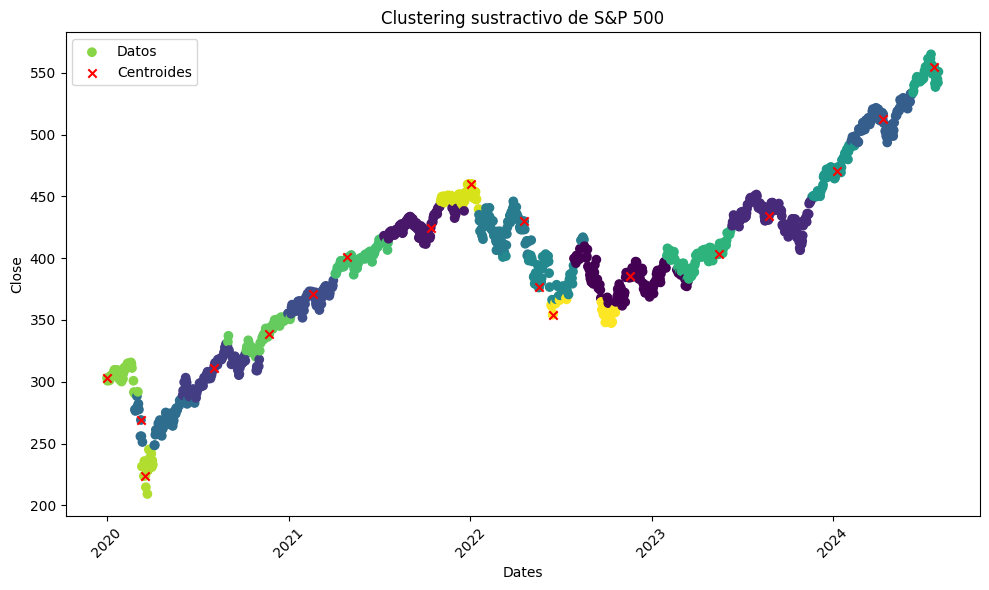

--- 0.10090947151184082 seconds ---
Soluciones ajustadas (coeficientes lineales):
[1.17902694e-01 3.00116692e+02]
--- 0.0686178207397461 seconds ---
Soluciones ajustadas (coeficientes lineales):
[1.17902694e-01 3.00116692e+02]
--- 0.06986832618713379 seconds ---
Soluciones ajustadas (coeficientes lineales):
[1.17902694e-01 3.00116692e+02]
--- 0.07587170600891113 seconds ---
Soluciones ajustadas (coeficientes lineales):
[1.17902694e-01 3.00116692e+02]
--- 0.11810660362243652 seconds ---
Soluciones ajustadas (coeficientes lineales):
[-9.93749711e+00 -3.00227419e+03 -4.29456097e+00  9.01534473e+03
 -5.31957157e+00  1.10592385e+04]
--- 0.10021853446960449 seconds ---
Soluciones ajustadas (coeficientes lineales):
[-9.93749711e+00 -3.00227419e+03 -4.29456097e+00  9.01534473e+03
 -5.31957157e+00  1.10592385e+04]
--- 0.09937429428100586 seconds ---
Soluciones ajustadas (coeficientes lineales):
[-1.41347055e+01 -4.28172568e+03 -5.69537184e+00  1.20082540e+04
 -6.65828878e+00  1.51492017e+04]
--

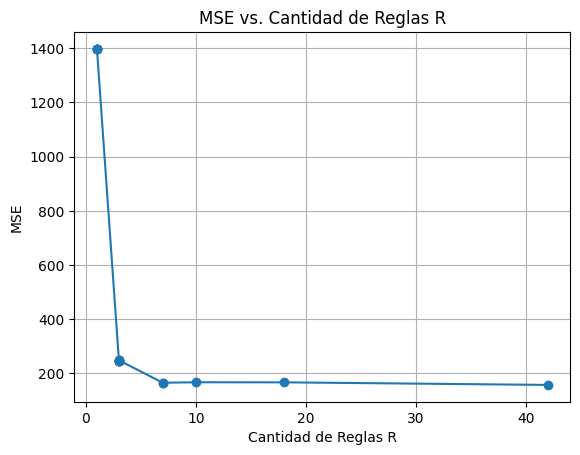

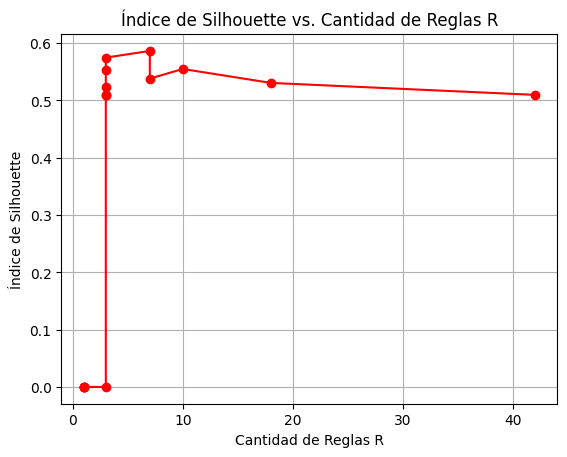

--- 0.1419074535369873 seconds ---
Soluciones ajustadas (coeficientes lineales):
[ 7.67921379e+04  1.92406416e+09  5.45702880e+05 -1.34757310e+09
  8.37631715e+04  3.68648580e+08 -1.77820700e+05 -5.40583298e+08
  2.68182517e+05  3.07935701e+08  8.45014745e+05 -7.84158909e+08
 -5.17058800e+05 -6.74963922e+08]
Mejor índice de Silhouette: 10
Mejor radio seleccionado: 0.5


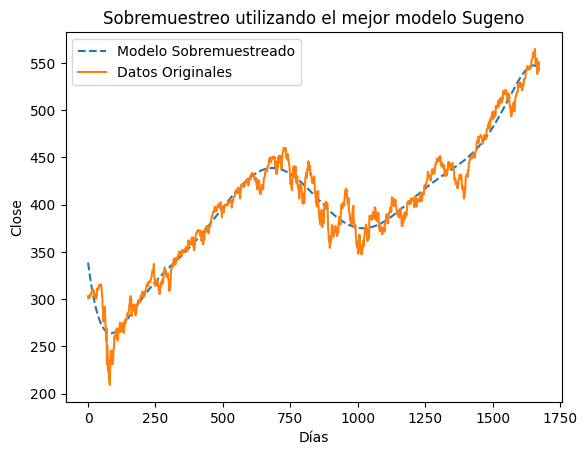

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix
import matplotlib.dates as mdates
from sklearn.metrics import silhouette_score

# Cargar el CSV
df = pd.read_csv('spytest.csv')

# Convertir la columna 'Date' a formato datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')

# Crear una nueva columna con el número de días desde el inicio para Date
df['Days'] = (df['Date'] - df['Date'].min()).dt.days

# Seleccionar las columnas necesarias para el clustering
data = df[['Days', 'Close']].values

def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb == 0:
        Rb = Ra * 1.15

    # Normalizar los datos
    scaler = MinMaxScaler()
    scaler.fit(data)
    ndata = scaler.transform(data)

    # Calcular la matriz de distancias
    P = distance_matrix(ndata, ndata)
    alpha = (Ra / 2) ** 2
    P = np.sum(np.exp(-P ** 2 / alpha), axis=0)

    centers = []
    i = np.argmax(P)
    C = ndata[i]
    p = P[i]
    centers = [C]

    continuar = True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P = P - p * np.array([np.exp(-np.linalg.norm(v - C) ** 2 / (Rb / 2) ** 2) for v in ndata])
        restarP = True
        i = np.argmax(P)
        C = ndata[i]
        p = P[i]
        if p > AcceptRatio * pAnt:
            centers = np.vstack((centers, C))
        elif p < RejectRatio * pAnt:
            continuar = False
        else:
            dr = np.min([np.linalg.norm(v - C) for v in centers])
            if dr / Ra + p / pAnt >= 1:
                centers = np.vstack((centers, C))
            else:
                P[i] = 0
                restarP = False
        if not any(v > 0 for v in P):
            continuar = False

    distancias = [[np.linalg.norm(p - c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)  # Volver a la escala original

    return labels, centers

# Aplicar el algoritmo
labels, centers = subclust2(data, Ra=0.2)

# Mostrar resultados
df['Cluster'] = labels

# Graficar los clusters
plt.figure(figsize=(10,6))

# Graficar puntos de Close vs Date y colorear por clusters
plt.scatter(df['Date'], df['Close'], c=labels, cmap='viridis', label='Datos')

# Asegurarse que los centroides se ploteen correctamente en el gráfico
plt.scatter(df['Date'].min() + pd.to_timedelta(centers[:, 0], unit='D'), centers[:, 1], color='red', marker='x', label='Centroides')

# Etiquetas
plt.xlabel('Dates')
plt.ylabel('Close')
plt.title('Clustering sustractivo de S&P 500')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


################################# SUGENO ################################

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time

# Función de pertenencia Gaussiana
def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))

class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma

class fisInput:
    def __init__(self, min, max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids

    def view(self):
        x = np.linspace(self.minValue, self.maxValue, 20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue - self.maxValue) / np.sqrt(8)
            y = gaussmf(x, m, s)
            plt.plot(x, y)

class fis:
    def __init__(self):
        self.rules = []
        self.memberfunc = []
        self.inputs = []

    def genfis(self, data, radii):
        start_time = time.time()

        # Aplicar el clustering sustractivo para obtener las etiquetas y centros
        labels, cluster_center = subclust2(data, radii)

        print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)

        # Excluir la última columna (variable objetivo)
        cluster_center = cluster_center[:, :-1]
        P = data[:, :-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)

        # Crear los inputs basados en los clusters
        self.inputs = [fisInput(minValue[i], maxValue[i], cluster_center[:, i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        P = data[:, :-1]
        T = data[:, -1]

        # Mínimos cuadrados para ajustar la salida
        sigma = np.array([(i.maxValue - i.minValue) / np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P, cluster, sigma), axis=1) for cluster in self.rules]

        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti, axis=1))

        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]

        # Crear matrices para mínimos cuadrados
        orden = np.tile(np.arange(0, n_vars), len(self.rules))
        acti = np.tile(nivel_acti, [1, n_vars])
        inp = P[:, orden]

        # Matriz A para mínimos cuadrados
        A = acti * inp / sumMu
        b = T

        # Resolver sistema de ecuaciones lineales
        solutions, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
        self.solutions = solutions
        print("Soluciones ajustadas (coeficientes lineales):")
        print(solutions)

    def evalfis(self, data):
        sigma = np.array([(input.maxValue - input.minValue) for input in self.inputs]) / np.sqrt(8)
        f = [np.prod(gaussmf(data, cluster, sigma), axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti, axis=1))

        P = np.c_[data, np.ones(len(data))]
        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0, n_vars), n_clusters)
        acti = np.tile(nivel_acti, [1, n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti * inp * coef / sumMu, axis=1)

    def viewInputs(self):
        for input in self.inputs:
            input.view()


###################################################################################################################

# Modificación para graficar el MSE y el índice de Silhouette vs. cantidad de reglas
errores = []
reglas = []
silhouettes = []
radios = np.arange(0.01, 1, 0.05)

for radio in radios[::-1]:
    fis2 = fis()
    fis2.genfis(data, radio)

    # Guardar la cantidad de reglas
    reglas.append(len(fis2.rules))

    # Evaluación
    predicciones = fis2.evalfis(data[:, :-1])

    # Calcular el MSE
    error = data[:, -1] - predicciones
    mse = np.sum(error ** 2) / len(data)
    errores.append(mse)

    # Calcular el índice de Silhouette
    labels = subclust2(data[:, :-1], radio)[0]
    # Calcular el índice de Silhouette si hay más de un cluster
    if len(np.unique(labels)) > 1:
        silhouette_avg = silhouette_score(data[:, :-1], labels)
        silhouettes.append(silhouette_avg)
    else:
        silhouettes.append(0)  # Agregar 0 si solo hay un cluster

# Graficar MSE vs. cantidad de reglas
plt.figure()
plt.plot(reglas, errores, marker='o', label='MSE')
plt.xlabel("Cantidad de Reglas R")
plt.ylabel("MSE")
plt.title("MSE vs. Cantidad de Reglas R")
plt.grid(True)
plt.show()

# Graficar el índice de Silhouette vs. cantidad de reglas R
plt.figure()
plt.plot(reglas, silhouettes, marker='o', color='r', label='Índice de Silhouette')
plt.xlabel("Cantidad de Reglas R")
plt.ylabel("Índice de Silhouette")
plt.title("Índice de Silhouette vs. Cantidad de Reglas R")
plt.grid(True)
plt.show()

# Selección del mejor modelo según el índice de Silhouette
mejor_indice = np.argmax(silhouettes)  # El índice máximo del índice de Silhouette
mejor_radio = radios[::-1][mejor_indice]
mejor_modelo = fis()
mejor_modelo.genfis(data, mejor_radio)

print(f"Mejor índice de Silhouette: {mejor_indice}")
print(f"Mejor radio seleccionado: {mejor_radio}")

# Sobremuestreo con el mejor modelo
datos_sobremuestreados = np.arange(0, max(df['Days']), 0.1)
resultados_sobremuestreados = mejor_modelo.evalfis(np.vstack(datos_sobremuestreados))

plt.figure()
plt.plot(datos_sobremuestreados, resultados_sobremuestreados, linestyle='--', label="Modelo Sobremuestreado")
plt.plot(df['Days'], df['Close'], label="Datos Originales")
plt.legend()
plt.title("Sobremuestreo utilizando el mejor modelo Sugeno")
plt.xlabel("Días")
plt.ylabel("Close")
plt.show()
